# ProShares Replication

## HBS Case

### *ProShares Hedge Replication ETF*

***

# Section 2:  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `May 2025`.

-----

## Question 2.1 

For the series in the "hedge fund series" tab, report the following summary statistics:

(a) mean

(b) volatility

(c) Sharpe ratio

Annualize these statistics.

In [2]:
# Question 2.1 (a) Code Here
import pandas as pd
import numpy as np

FILE_PATH = "../data/proshares_analysis_data.xlsx"

frequency=12

# Load the Excel sheet
df = pd.read_excel(FILE_PATH, sheet_name="hedge_fund_series", index_col=0)

#drop empty rows
df = df.dropna(how="all", axis=0).dropna(how="all", axis=1)

#computing stats
mean_monthly    =   df.mean(numeric_only=True)
vol_monthly     =   df.std(numeric_only=True)

#annualizing
mean_annual     =   mean_monthly*frequency
vol_annual      =   vol_monthly*(np.sqrt(frequency))
Sharpe_annual   =   mean_monthly/vol_monthly*(np.sqrt(frequency))

#new dataframe
results = pd.DataFrame({
    "Mean (annualised)":        mean_annual,
    "Volatility (annualised)":  vol_annual,
    "Sharpe ratio":             Sharpe_annual
}).round(4)
print(results)


                Mean (annualised)  Volatility (annualised)  Sharpe ratio
HFRIFWI Index              0.0513                   0.0588        0.8722
MLEIFCTR Index             0.0385                   0.0552        0.6976
MLEIFCTX Index             0.0365                   0.0551        0.6629
HDG US Equity              0.0269                   0.0574        0.4684
QAI US Equity              0.0288                   0.0498        0.5783


In [3]:
# Question 2.1 (b) Code Here

In [4]:
# Question 2.1 (c) Code Here

-----

## Question 2.2

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk:

(a) Skewness

(b) Excess Kurtosis (in excess of 3)

(c) VaR (.05) - the fifth quantile of historic returns

(d) CVaR (.05) - the mean of the returns at or below the fifth quantile

(e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [5]:
# Question 2.2 (a) Code Here
skewness                    =   df.skew(numeric_only=True)
kurtosis                    =   df.kurtosis(numeric_only=True)-3
value_at_risk               =   df.quantile(q=0.2, numeric_only=True)
conditional_value_at_risk   =   df.apply(lambda s: s[s <= s.quantile(q=0.2)].mean(), axis=0)

In [6]:
# Question 2.2 (b) Code Here
#drawdown
acumulated_returns = (1 + df).cumprod()
current_peak = acumulated_returns.cummax()
drawdown = acumulated_returns / current_peak - 1.0      # same shape as df

rows = {}
for col in df.columns:
    dd = drawdown[col]
    w  = acumulated_returns[col]
    rp = current_peak[col]

    if dd.isna().all():
        rows[col] = [pd.NaT, pd.NaT, pd.NaT, np.nan]
        continue

    trough_date = dd.idxmin()                     # date of max drawdown (most negative)
    peak_val    = rp.loc[trough_date]             # level of the prior peak
    peak_date   = rp.loc[:trough_date].idxmax()   # first time that peak was set

    # first date on/after trough when wealth >= prior peak (may be never)
    rec_mask = w.loc[trough_date:].ge(peak_val)
    recovery_date = rec_mask.idxmax() if rec_mask.any() else pd.NaT

    rows[col] = [peak_date, trough_date, recovery_date, dd.min()]

summary = pd.DataFrame.from_dict(
    rows, orient="index",
    columns=["peak_date", "trough_date", "recovery_date", "max_drawdown"]
)


In [7]:
# Question 2.2 (c) Code Here
results = pd.DataFrame({
    "Skewness":        skewness,
    "Kurtosis":        kurtosis,
    "VaR":             value_at_risk, 
    "CVaR":            conditional_value_at_risk
}).round(4)
print(results)
print(summary)

                Skewness  Kurtosis     VaR    CVaR
HFRIFWI Index    -0.9483    2.6574 -0.0061 -0.0188
MLEIFCTR Index   -0.2900   -1.3691 -0.0061 -0.0198
MLEIFCTX Index   -0.2735   -1.4102 -0.0062 -0.0200
HDG US Equity    -0.2749   -1.2235 -0.0084 -0.0215
QAI US Equity    -0.4335   -1.5508 -0.0082 -0.0176
                peak_date trough_date recovery_date  max_drawdown
HFRIFWI Index  2019-12-31  2020-03-31    2020-08-31     -0.115473
MLEIFCTR Index 2021-06-30  2022-09-30    2024-02-29     -0.124302
MLEIFCTX Index 2021-06-30  2022-09-30    2024-02-29     -0.124388
HDG US Equity  2021-06-30  2022-09-30    2024-07-31     -0.140720
QAI US Equity  2021-06-30  2022-09-30    2024-02-29     -0.137716


In [8]:
# Question 2.2 (d) Code Here

In [9]:
# Question 2.2 (e) Code Here

-----

## Question 2.3

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:

(a) Market Beta

(b) Treynor Ratio

(c) Information ratio

Annualize these three statistics as appropriate.

In [24]:
# Question 2.3 (a) Code Here
import statsmodels.api as sm
#I assume risk free is 0
#rf=0

#target
target_col  = 'SPY US Equity'

# Load the Excel sheet
factor = pd.read_excel(FILE_PATH, sheet_name="merrill_factors", index_col=0)
factor = factor.dropna(how="all", axis=0).dropna(how="all", axis=1)
data=df.join(factor[[target_col]], how='inner')

#computing betas
results=[]
for columns in df.columns:
    y=df[columns]
    x=sm.add_constant(data[target_col])
    model=sm.OLS(y, x, missing='drop').fit()

    excess_return=y.mean()
    unexplained_return=(y-data[target_col])
    
    treynor_ratio=excess_return/model.params[target_col]
    information_ratio=unexplained_return.mean()/unexplained_return.std()
    results.append({
        "asset" :   columns, 
        "alpha" :   model.params['const'], 
        "beta"  :   model.params[target_col],
        "r2"    :   model.rsquared,
        "Treynor ratio": treynor_ratio*frequency,
        "Information ratio": information_ratio*np.sqrt(frequency)
    })

summary = pd.DataFrame(results).set_index("asset").sort_index()
print(summary)


                   alpha      beta        r2  Treynor ratio  Information ratio
asset                                                                         
HDG US Equity  -0.001989  0.350602  0.767456       0.076669          -1.213227
HFRIFWI Index   0.000144  0.346312  0.716217       0.148072          -0.927074
MLEIFCTR Index -0.000920  0.342487  0.790416       0.112514          -1.087986
MLEIFCTX Index -0.001075  0.341483  0.789721       0.106963          -1.107047
QAI US Equity  -0.001235  0.301413  0.752559       0.095587          -1.123406


In [11]:
# Question 2.3 (b) Code Here

In [12]:
# Question 2.3 (c) Code Here

-----

## Question 2.4

Discuss the previous statistics, and what they tell us about...

(a) the differences between SPY and the hedge-fund series?

(b) which performs better between HDG and QAI.

(c) whether HDG and the ML series capture the most notable properties of HFRI.

### Question 2.4 (a) Answer

The hedge-fund series provide much lower market exposure. The beta related to all of them is between 0.30 and 0.35. Also, The R-squared indicates that not all of their movements are explained by the market.

Also, all of the funds have underperformed the SPY as a bechmark over the sample given that all of the alphas are negative with the expection of HRFI. In that sense, the inforation ratio confirms this as they are also negative for each one of the funds. This indicates negative returns per unit of risk. 

### Question 2.4 (b) Answer

QAI seems to have a better performance than HDG. It has higher Treynor and information ratio, whihc indicated better returns per unit of risk. In addition, it has a lower beta which indicates less exposure to systematic risk.

### Question 2.4 (c) Answer

They do not replicate HRFI most notable properties. On one hand, they provide similar market exposure as the betas are very similar. On the other hand, they lag HFRI in performance metrics as the Treynor and informaiton ratios. Therefore, they do not provide the same characteristics as HFRI

-----

## Question 2.5 

Report the correlation matrix for these assets.

(a) Show the correlations as a heat map.

(b) Which series have the highest and lowest correlations?


Greatest Positive Correlation: MLEIFCTR Index & MLEIFCTX Index (1.000)
Greatest Negative Correlation:  HFRIFWI Index & QAI US Equity (0.858)
Least Correlated Pair: HFRIFWI Index & QAI US Equity (0.858)


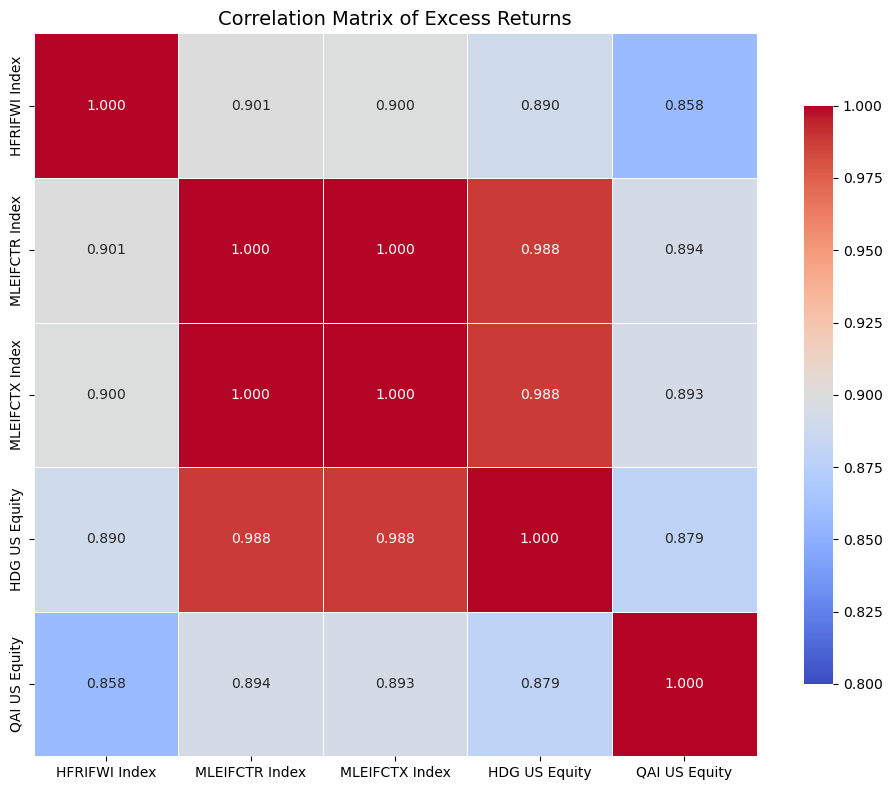

In [ ]:
# Question 2.5 (a) Code Here
import matplotlib.pyplot as plt
import seaborn as sns

#from HW1
# Correlation matrix of monthly excess returns
corr_matrix = df.corr()

# Round for readability
corr_matrix_rounded = corr_matrix.round(3)

# Find highest and lowest correlation
# Stack the matrix into pairs, dropping self-correlations
corr_pairs = corr_matrix.stack().reset_index()
corr_pairs.columns = ["Asset1", "Asset2", "Correlation"]

# Keep only unique pairs
corr_pairs = corr_pairs[corr_pairs["Asset1"] < corr_pairs["Asset2"]]

# Identify max and min correlation pairs
max_corr = corr_pairs.loc[corr_pairs["Correlation"].idxmax()]
min_corr = corr_pairs.loc[corr_pairs["Correlation"].idxmin()]

# display
print(f"\nGreatest Positive Correlation: {max_corr['Asset1']} & {max_corr['Asset2']} ({max_corr['Correlation']:.3f})")
print(f"Greatest Negative Correlation:  {min_corr['Asset1']} & {min_corr['Asset2']} ({min_corr['Correlation']:.3f})")

# Find pair with correlation closest to zero
min_abs_corr = corr_pairs.iloc[(corr_pairs['Correlation'].abs()).argmin()]
print(f"Least Correlated Pair: {min_abs_corr['Asset1']} & {min_abs_corr['Asset2']} ({min_abs_corr['Correlation']:.3f})")

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".3f",
    cmap="coolwarm", center=0.9, vmin=0.8, vmax=1,
    square=True, linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title("Correlation Matrix of Excess Returns", fontsize=14)
plt.tight_layout()
plt.show()


In [14]:
# Qustion 2.5 (b) Code Here

-----

## Question 2.6  

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,  

$$
\begin{aligned}
r_t^{\mathrm{HFRI}} &= \alpha^{\mathrm{merr}} + x_t^{\mathrm{merr}}\beta^{\mathrm{merr}} + \epsilon_t^{\mathrm{merr}} \\[6pt]
\hat r_t^{\mathrm{HFRI}} &= \hat\alpha^{\mathrm{merr}} + x_t^{\mathrm{merr}}\hat\beta^{\mathrm{merr}}
\end{aligned}
$$  

Note that the second equation is just our notation for the fitted replication.  

(a) Report the intercept and betas.  

(b) Are the betas realistic position sizes, or do they require huge long-short positions?  

(c) Report the R-squared.  

(d) Report the volatility of $\epsilon^{\mathrm{merr}}$, the tracking error.  


In [15]:
# Question 2.6 (a) Code Here
target_col  = "HFRIFWI Index"
factor_cols = ["USGG3M Index","SPY US Equity","IWM US Equity",
               "EUO US Equity","EFA US Equity","EEM US Equity"]

# Align data
replication_df = factor[factor_cols].join(df[[target_col]], how="inner")

# OLS with intercept
y = replication_df[target_col]
X = sm.add_constant(replication_df[factor_cols])
model = sm.OLS(y, X, missing="drop").fit()

# (a) Intercept and betas
alpha = model.params["const"]
betas = model.params.drop("const").rename("beta")

betas_table = betas.to_frame()
betas_table.loc["(Intercept)","beta"] = alpha

# (b)
gross_exposure = betas.abs().sum() 
max_abs_beta   = betas.abs().max()
realism_flags  = pd.Series({
    "gross_exposure": gross_exposure,
    "max_abs_beta":   max_abs_beta
})

# (c) R-squared
r2 = model.rsquared

# (d) Tracking error (volatility of residuals)
resid = model.resid.dropna()
te_monthly = resid.std(ddof=1)
te_annual  = np.sqrt(12) * te_monthly

# Fitted replication series
replicated = model.fittedvalues.rename("hfri_replication")

# outputs
print("(a) Intercept and Betas")
print(betas_table)

print("\n(b) Position Size Checks")
print(realism_flags)

print("\n(c) R-squared")
print(f"R^2 = {r2:.4f}")

print("\n(d) Tracking Error (Residual Volatility)")
print(f"Monthly TE  = {te_monthly:.6f}")
print(f"Annual  TE  = {te_annual:.6f}")

# summary
summary = pd.DataFrame({
    "alpha": [alpha],
    "R2": [r2],
    "TE_monthly": [te_monthly],
    "TE_annual": [te_annual],
    "gross_exposure": [gross_exposure],
    "max_abs_beta": [max_abs_beta]
}, index=[target_col])
print("\nSummary")
print(summary)

#out = pd.concat([replication_df[[target_col]], replicated], axis=1)

(a) Intercept and Betas
                   beta
USGG3M Index   0.324931
SPY US Equity  0.043503
IWM US Equity  0.145824
EUO US Equity  0.029614
EFA US Equity  0.073994
EEM US Equity  0.085564
(Intercept)    0.001149

(b) Position Size Checks
gross_exposure    0.703430
max_abs_beta      0.324931
dtype: float64

(c) R-squared
R^2 = 0.8427

(d) Tracking Error (Residual Volatility)
Monthly TE  = 0.006732
Annual  TE  = 0.023320

Summary
                  alpha        R2  TE_monthly  TE_annual  gross_exposure  \
HFRIFWI Index  0.001149  0.842694    0.006732    0.02332         0.70343   

               max_abs_beta  
HFRIFWI Index      0.324931  


In [16]:
# Question 2.6 (b) Code Here

In [17]:
# Question 2.6 (c) Code Here

In [18]:
# Question 2.6 (d) Code Here

-----

## Question 2.7  

Let's examine the replication out-of-sample (OOS).  

Starting with $t = 61$ month of the sample, do the following:  

(a) Use the previous 60 months of data to estimate the regression equation.  
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\mathrm{merr}}_{t}$ and $\tilde{\beta}^{\mathrm{merr}}_{t}$.  

(b) Use the estimated regression parameters, along with the time-t regressor values, $x^{\mathrm{merr}}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).  

$$
\hat r_t^{\mathrm{HFRI}} \equiv \tilde{\alpha}^{\mathrm{merr}} + (x_t^{\mathrm{merr}})^\prime \tilde{\beta}^{\mathrm{merr}}
$$  

(c) Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.  

(d) How well does the out-of-sample replication perform with respect to the target?  


            y_true    y_pred  oos_error  alpha_roll
2025-05-31  0.0223  0.018062   0.004238    0.005986
2025-06-30  0.0233  0.021267   0.002033    0.005902
2025-07-31  0.0097  0.006974   0.002726    0.005835
2025-08-31  0.0221  0.020107   0.001993    0.005197
2025-09-30     NaN  0.015602        NaN    0.004995


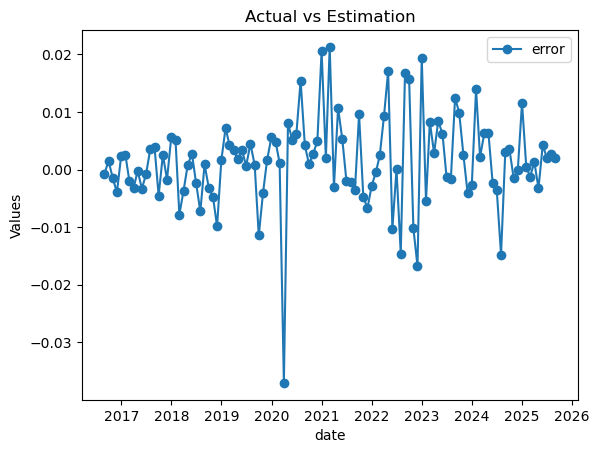

In [19]:
# Question 2.7 (a) Code Here
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

target_col  = "HFRIFWI Index"
factor_cols = ["USGG3M Index","SPY US Equity","IWM US Equity",
               "EUO US Equity","EFA US Equity","EEM US Equity"]
window=60
# Align data
panel = factor[factor_cols].join(df[[target_col]], how="inner")

predictions, errors, alphas, betas_rows= [], [], [], []

cols_needed=[target_col]+factor_cols

for i in range(window, len(panel)):
    train=panel.iloc[i-window:i]
    train=train.dropna(subset=cols_needed)

    if len(train)<window:
        continue

    #model
    y = train[target_col]
    X = sm.add_constant(train[factor_cols])
    model = sm.OLS(y, X).fit()

    # Next point to predict
    x_next = panel[factor_cols].iloc[i:i+1]

    x_next = sm.add_constant(x_next, has_constant='add')
    y_hat = float(model.predict(x_next))

    idx = panel.index[i]
    y_true = float(panel[target_col].iloc[i])

    #store information
    predictions.append((idx, y_hat))
    errors.append((idx, y_true - y_hat))
    alphas.append((idx, model.params["const"]))

df_pred     = pd.Series(dict(predictions), name="y_pred")
df_error    = pd.Series(dict(errors),  name="oos_error")
df_alpha    = pd.Series(dict(alphas), name="alpha_roll")
df_betas    = pd.DataFrame(betas_rows)

# y_true aligned to prediction dates
y_true = panel[target_col].reindex(df_pred.index).rename("y_true")

# Combine them
final_results = pd.concat(
    [
        y_true.to_frame(),
        df_pred.to_frame(),
        df_error.to_frame(),
        df_alpha.to_frame(),
        df_betas,
    ],
    axis=1
)

#showing results and graphing
print(final_results.tail())

#plt.plot(final_results.index, final_results['y_true'], label='Actual', marker='o')
#plt.plot(final_results.index, final_results['y_pred'], label='Estimation', marker='p')
plt.plot(final_results.index, final_results['oos_error'], label='error', marker='o')
# Adding labels and title
plt.xlabel('date')
plt.ylabel('Values')
plt.title('Actual vs Estimation')
plt.legend()

# Display the plot
plt.show()

The estimation does well before 2020, with the size of errors being relative small. 
However, the size of errors increases over time and the predictions seem to lose power. 
In that sense, there seems to be heterocedasticty as the variance of the erros increases as well
So, the predicitions become questionable. 

In [20]:
# Question 2.7 (b) Code Here

In [21]:
# Question 2.7 (c) Code Here

In [22]:
# Question 2.7 (d) Code Here